In [1]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix
from transformers import BertTokenizer,BertModel,AdamW,get_linear_schedule_with_warmup
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import sqlite3 as sql
from textblob import TextBlob

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

warnings.filterwarnings("ignore")

con = sql.connect("C:/sql/databases/data.db")


query_tables = """
SELECT name 
FROM sqlite_master 
WHERE type='table' 
AND sql LIKE '%CREATE TABLE%' 
AND sql LIKE '%com%';
"""
tables_df = pd.read_sql_query(query_tables, con)
table_names = tables_df["name"].tolist()  


df = pd.DataFrame()

for table in table_names:
    query = f"SELECT * FROM {table};"
    data = pd.read_sql_query(query, con)
    data["board"] = table
    df = pd.concat([df, data], ignore_index=True)

print(df.head(10))


cuda:0
         no                    now  \
0  90720277  10/25/23(Wed)22:11:21   
1  90744590  10/28/23(Sat)04:24:25   
2  90744593  10/28/23(Sat)04:25:27   
3  90744611  10/28/23(Sat)04:29:00   
4  90745873  10/28/23(Sat)08:59:00   
5  90746799  10/28/23(Sat)11:05:08   
6  90736952  10/27/23(Fri)12:22:24   
7  90744915  10/28/23(Sat)05:50:06   
8  90744988  10/28/23(Sat)06:04:22   
9  90746040  10/28/23(Sat)09:24:26   

                                                 com board  
0  The average human male is 5' 4". The tallest h...    tg  
1  He did not say american male, he said HUMAN male.    tg  
2  As of recent studies, the average height in th...    tg  
3  1980-1994doesn't have southern asia (3 billion...    tg  
4  I just assume that in general fiction the rigi...    tg  
5  Dwarves are between 4'4 to 5'4 but average out...    tg  
6  is r scott bakker /tg/ approved?how would you ...    tg  
7  I'm still amazed at how perfectly this fits th...    tg  
8  It’s definitely /tg/ a

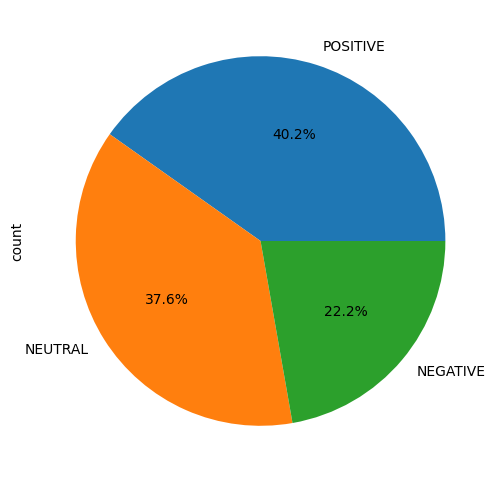

In [2]:

sample_txt = " ".join(i for i in df['com'])



def polarity(text):
    return TextBlob(text).polarity


df['polarity'] = df['com'].apply(polarity)


def Sentiment(label):
    if label > 0:
        return "POSITIVE"
    elif label == 0:
        return "NEUTRAL"
    elif label < 0:
        return "NEGATIVE"



df['Sentiment'] = df['polarity'].apply(Sentiment)

plt.figure(figsize=(10,6))
df['Sentiment'].value_counts().plot(kind='pie',autopct="%1.1f%%")
plt.show()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


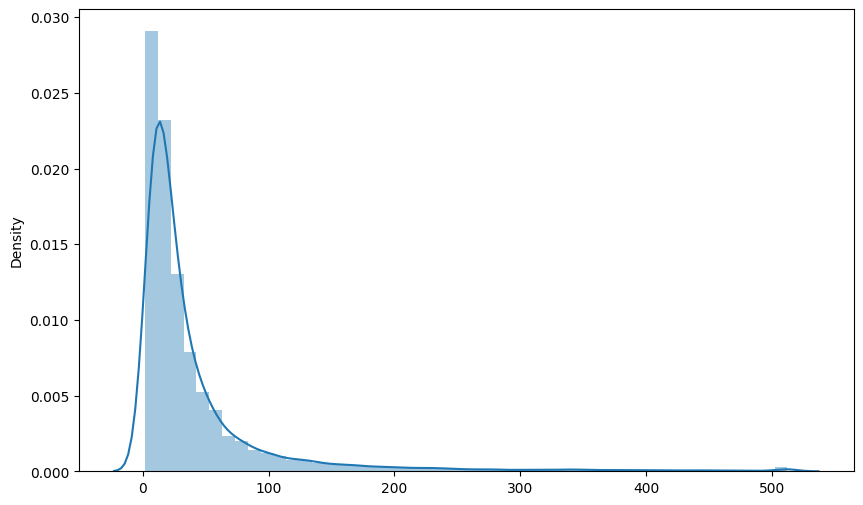

In [3]:
df = df[['com','Sentiment']]


df.duplicated().sum()
df.drop_duplicates(inplace=True)
df['Sentiment'] = LabelEncoder().fit_transform(df['Sentiment'])



MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)


sample_tokens = []
for txt in df['com']:
    tokens = tokenizer.encode(txt,max_length=512)
    sample_tokens.append(len(tokens))


plt.figure(figsize=(10,6))
sns.distplot(sample_tokens)
plt.show()

In [4]:
MAX_LEN = 200


class Custom_Dataset(torch.utils.data.Dataset):
    def __init__(self,com,targets,max_len,tokenizer):
        self.com = com
        self.targets = targets
        self.max_len = max_len
        self.tokenizer = tokenizer
        
    def __len__(self):
        return len(self.com)
    
    def __getitem__(self,idx):
        com = str(self.com[idx])
        target = self.targets[idx]
        
        
        encoder = self.tokenizer.encode_plus(
            com,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_token_type_ids=False,
            return_tensors='pt',
            )
        
        return {
            "com":com,
            "input_ids":encoder['input_ids'].flatten(),
            "attention_mask":encoder['attention_mask'].flatten(),
            "targets":torch.tensor(target,dtype=torch.long)
            }




df_train,df_test = train_test_split(df,test_size=.10,random_state=42)
df_val,df_test = train_test_split(df_test, test_size=50,random_state=42)

BATCH_SIZE = 16

def get_dataloader(df,tokenizer,max_len,batch_size):
    ds = Custom_Dataset(
        com = df['com'].to_numpy(),
        targets = df['Sentiment'].to_numpy(),
        max_len=max_len,
        tokenizer=tokenizer
        )
    return torch.utils.data.DataLoader(
        ds,
        num_workers=0,
        batch_size=batch_size
        )

train_dataloader = get_dataloader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_dataloader = get_dataloader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)
val_dataloader = get_dataloader(df_val,tokenizer,MAX_LEN,BATCH_SIZE)


data = next(iter(train_dataloader))
data.keys()

dict_keys(['com', 'input_ids', 'attention_mask', 'targets'])

In [5]:

class Bert_Classifier(nn.Module):
    def __init__(self):
        super(Bert_Classifier,self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(768,3)
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
        input_ids=input_ids,
        attention_mask=attention_mask
    )
        pooled_output = outputs.pooler_output
        output = self.drop(pooled_output)
        return self.out(output)
    
model = Bert_Classifier()
model.to(device)


Bert_Classifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [6]:
epochs = 4
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = AdamW(model.parameters(),lr=2e-5,correct_bias=False)
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)




def training_epoch(model,dataloader,loss_fn,optimizer,device,scheduler,n_examples):
    model.train()
    losses = []
    predictions = 0
    for d in dataloader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        targets = d['targets'].to(device)
        
        outputs = model(
            attention_mask=attention_mask,
            input_ids=input_ids
            )
        _,preds = torch.max(outputs,dim=1)
        loss = loss_fn(outputs,targets)
        predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
    return (predictions.double() / n_examples,np.mean(losses))



def eval_model(model,dataloader,loss_fn,device,n_examples):
    model.eval()
    losses = []
    predictions = 0
    
    
    with torch.no_grad():
        for d in dataloader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['targets'].to(device)
            
            outputs = model(
                attention_mask=attention_mask,
                input_ids=input_ids
                )
            
            _,preds = torch.max(outputs,dim=1)
            loss = loss_fn(outputs,targets)
            
            predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
        return (predictions.double() / n_examples,np.mean(losses))






for epoch in range(epochs):
    print(f'{epoch+1}/{epochs}')
    
    train_acc,train_loss = training_epoch(
        model,
        train_dataloader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
        )
    
    
    val_acc,val_loss = eval_model(model, val_dataloader, loss_fn, device, len(df_val))
    print(f" Training accuracy {train_acc*100:.2f}%; -Val Accuracy-- {val_acc*100:.2f}%")
    print(f"training loss {train_loss*100:.2f}%; --val loss-- {val_loss*100:.2f}%")


1/4
 Training accuracy 85.09%; -Val Accuracy-- 90.74%
training loss 43.36%; --val loss-- 29.30%
2/4
 Training accuracy 93.61%; -Val Accuracy-- 92.41%
training loss 21.63%; --val loss-- 25.19%
3/4
 Training accuracy 96.40%; -Val Accuracy-- 93.00%
training loss 13.53%; --val loss-- 27.97%
4/4
 Training accuracy 97.73%; -Val Accuracy-- 93.38%
training loss 9.24%; --val loss-- 32.35%


In [7]:
test_acc, _ = eval_model(
  model,
  test_dataloader,
  loss_fn,
  device,
  len(df_test)
)

print(f'Testing Accuracy : {test_acc.item() *100 :.2f}%')

Testing Accuracy : 98.00%


In [16]:

def get_predictions(model, dataloader):
  model.eval()
  
  coms = []
  pred = []
  pred_prob = []
  real_values = []

  with torch.no_grad():
    for d in dataloader:

      com = d["com"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = torch.nn.functional.softmax(outputs, dim=1)

      coms.extend(com)
      pred.extend(preds)
      pred_prob.extend(probs)
      real_values.extend(targets)

  pred = torch.stack(pred).cpu()
  pred_prob = torch.stack(pred_prob).cpu()
  real_values = torch.stack(real_values).cpu()
  return coms, pred, pred_prob, real_values


y_coms,y_pred,y_pred_prob,y_test = get_predictions(model, test_dataloader)

In [17]:
clf_rpt = classification_report(y_test, y_pred)
print(f"Classification Report: {clf_rpt}")


Classification Report:               precision    recall  f1-score   support

           0       1.00      0.89      0.94         9
           1       1.00      1.00      1.00        18
           2       0.96      1.00      0.98        23

    accuracy                           0.98        50
   macro avg       0.99      0.96      0.97        50
weighted avg       0.98      0.98      0.98        50



<Axes: >

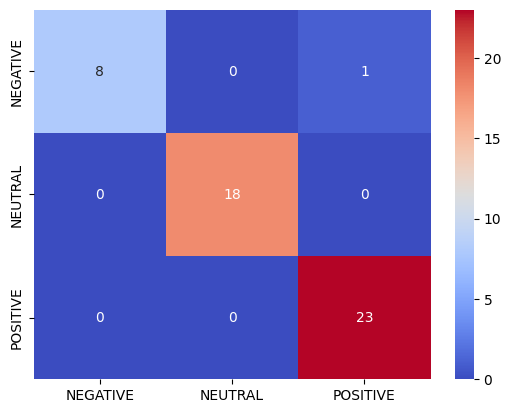

In [18]:
def plot_confusion_matrix(y_test,y_pred):
    cm = confusion_matrix(y_test, y_pred)
    return sns.heatmap(cm,fmt="d",annot=True,cmap="coolwarm",xticklabels=["NEGATIVE","NEUTRAL","POSITIVE"],yticklabels=["NEGATIVE","NEUTRAL","POSITIVE"])



plot_confusion_matrix(y_test, y_pred)


In [19]:

idx = 2
class_names = ["NEGATIVE","NEUTRAL","POSITIVE"]
y_coms = coms[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_prob[idx]
})


from textwrap import wrap

print("\n".join(wrap(y_coms)))
print(f'True sentiment: {class_names[true_sentiment]}')


True sentiment: NEGATIVE


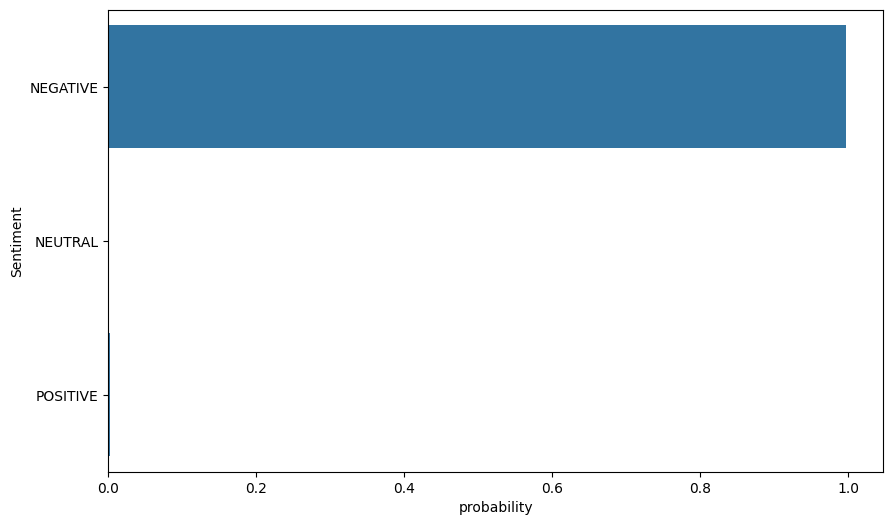

In [20]:
plt.figure(figsize=(10,6))
sns.barplot(x='values', y='class_names', data=pred_df)
plt.ylabel('Sentiment')
plt.xlabel('probability')
plt.show()

In [21]:
coms = "do you wanna go on a hike"

com_encoder = tokenizer.encode_plus(
    coms,
    max_length=MAX_LEN,
    padding="max_length",
    add_special_tokens=True,
    return_attention_mask=True,
    return_token_type_ids=False,
    return_tensors="pt",
    )

input_ids = com_encoder['input_ids'].to(device)
attention_mask = com_encoder['attention_mask'].to(device)
outputs = model(input_ids,attention_mask)
_,pred = torch.max(outputs,dim=1)

print(f"text from board: {coms}")
print(f"sentiment: {class_names[pred]}")

text from board: do you wanna go on a hike
sentiment: NEUTRAL
